In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
vectorizer_bag_of_frames = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bag_of_frames = vectorizer_bag_of_frames.fit_transform(list(s)).toarray()
df_bag_of_frames = pd.DataFrame(data = X_bag_of_frames, columns = vectorizer_bag_of_frames.get_feature_names())

In [7]:
X_train, X_validation, Y_train, Y_validation = train_test_split(df_measures.index, df_measures['PDM'], test_size = 0.2) 

In [8]:
indexes_train_1 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_train_2 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()
indexes_validation_1 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_validation_2 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()

In [9]:
X_train = dict()
X_train['stack_1'] = df_bag_of_frames.loc[indexes_train_1].values
X_train['stack_2'] = df_bag_of_frames.loc[indexes_train_2].values

X_validation = dict()
X_validation['stack_1'] = df_bag_of_frames.loc[indexes_validation_1].values
X_validation['stack_2'] = df_bag_of_frames.loc[indexes_validation_2].values

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

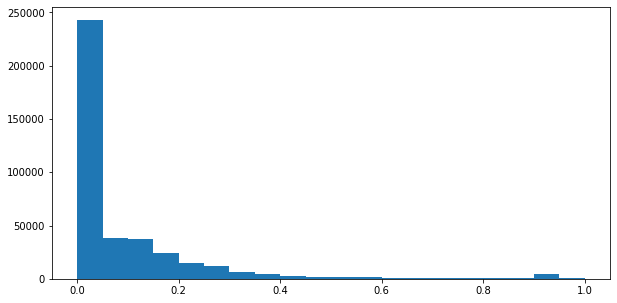

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

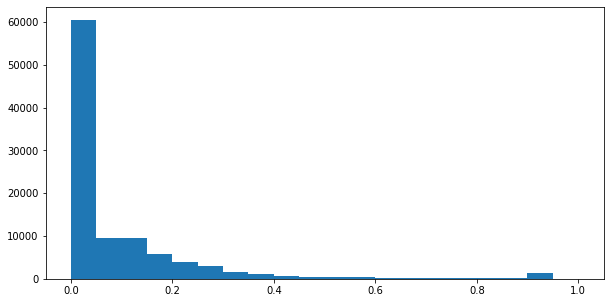

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [7]:
'Number of hash tables functions' 
m = 64

In [8]:
'Number of bits per hash function' 
b = 8

In [9]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

512

## 2.1. Feature learning phase

In [17]:
x = Sequential()
x.add(Dense(2048, input_dim = X_train['stack_1'].shape[1], activation = 'sigmoid'))
x.add(Dense(1024, activation = 'sigmoid'))
x.add(Dense(size_hash_vector, activation = 'tanh'))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (X_train['stack_1'].shape[1],)
model = siamese_model_baseline(shared_model, input_shape, is_sparse = True, print_summary = True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2244)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2244)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512)          7220736     input_1[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_2[0][0]                

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model_baseline(model, X_train, X_validation, Y_train, Y_validation, size_hash_vector, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 17s 21ms/step - loss: -0.2117 - manh_dist_loss: 0.0439 - abs_vect_loss: -0.9783 - abs_vect_1_loss: -0.9792 - manh_dist_rmse: 0.2096 - manh_dist_mae: 0.1330 - val_loss: -0.2300 - val_manh_dist_loss: 0.0234 - val_abs_vect_loss: -0.9897 - val_abs_vect_1_loss: -0.9903 - val_manh_dist_rmse: 0.1528 - val_manh_dist_mae: 0.1036
Epoch 2/20
781/781 [==============================] - 16s 20ms/step - loss: -0.2325 - manh_dist_loss: 0.0207 - abs_vect_loss: -0.9920 - abs_vect_1_loss: -0.9924 - manh_dist_rmse: 0.1440 - manh_dist_mae: 0.0969 - val_loss: -0.2339 - val_manh_dist_loss: 0.0194 - val_abs_vect_loss: -0.9938 - val_abs_vect_1_loss: -0.9937 - val_manh_dist_rmse: 0.1391 - val_manh_dist_mae: 0.0933
Epoch 3/20
781/781 [==============================] - 15s 20ms/step - loss: -0.2357 - manh_dist_loss: 0.0172 - abs_vect_loss: -0.9943 - abs_vect_1_loss: -0.9946 - manh_dist_rmse: 0.1310 - manh_dist_mae: 0.0881 - val_loss: -0.2370 - val_manh_dist_lo

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{Baseline}$

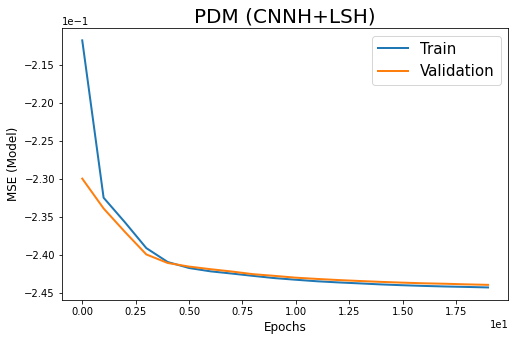

In [21]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history['loss'], linewidth = 2)
plt.plot(siamese_model.history['val_loss'], linewidth = 2)
plt.title('PDM (CNNH+LSH)', fontsize = 20)
plt.ylabel('MSE (Model)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of Similarity preserving loss

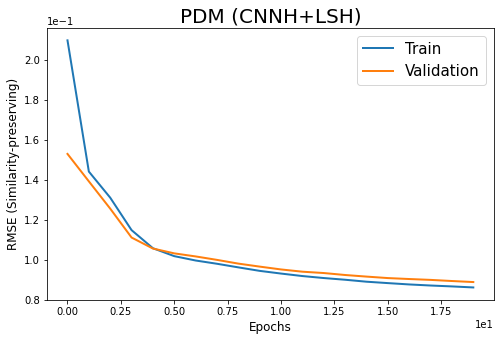

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('PDM (CNNH+LSH)', fontsize = 20)
plt.ylabel('RMSE (Similarity-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

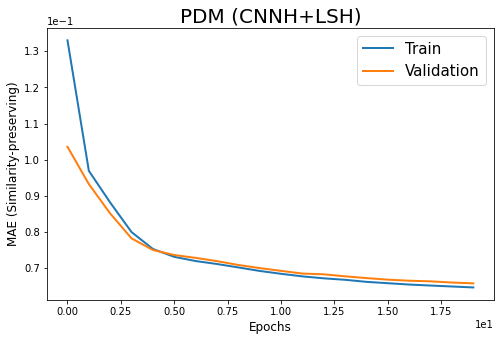

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('PDM (CNNH+LSH)', fontsize = 20)
plt.ylabel('MAE (Similarity-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.071, 0.036, 0.162, 0.083, 0.304, 0.143, 0.048, 0.191, 0.019,
       0.043, 0.174, 0.056, 0.258, 0.093, 0.05 , 0.25 , 0.327, 0.076,
       0.068, 0.038, 0.035, 0.201, 0.13 , 0.189, 0.387, 0.323, 0.046,
       0.198, 0.155, 0.048, 0.04 , 0.032, 0.89 , 0.096, 0.236, 0.021,
       0.294, 0.016, 0.029, 0.098, 0.031, 0.113, 0.335, 0.187, 0.018,
       0.178, 0.162, 0.033, 0.042, 0.052], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.   , 0.   , 0.174, 0.   , 0.263, 0.   , 0.   , 0.191, 0.   ,
       0.   , 0.174, 0.043, 0.31 , 0.101, 0.   , 0.   , 0.51 , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.164, 0.127, 0.309, 0.274, 0.   ,
       0.085, 0.061, 0.   , 0.   , 0.02 , 0.757, 0.   , 0.   , 0.   ,
       0.166, 0.   , 0.   , 0.   , 0.   , 0.   , 0.3  , 0.136, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

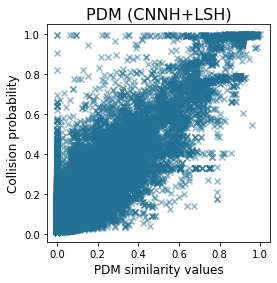

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('PDM (CNNH+LSH)', fontsize = 16)
plt.xlabel("PDM similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/Baseline/PDM-correlation', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.7350905014056323

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.5906242898918894

## 3.3. Approximate Hamming Evaluation

In [30]:
output_layer = 2
model.layers[output_layer]

In [31]:
intermediate_model = intermediate_model_trained(shared_model, output_layer)

In [32]:
intermediate_model.save('Models/model-baseline.model')

INFO:tensorflow:Assets written to: Models/model-baseline.model/assets


In [12]:
#import tensorflow as tf
#intermediate_model = tf.keras.models.load_model('Models/model-baseline.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [13]:
'First 64 bits'
intermediate_model.predict(df_bag_of_frames.iloc[[10]])[0][:64]

array([-0.96791524, -1.        , -1.        , -1.        ,  1.        ,
       -1.        ,  1.        , -0.9999801 ,  1.        ,  1.        ,
       -1.        , -1.        ,  1.        , -0.99960834,  1.        ,
        1.        ,  0.9992822 , -0.9972491 , -1.        ,  1.        ,
       -0.9993335 , -1.        , -1.        , -1.        ,  1.        ,
       -0.99999946,  1.        , -0.9998956 ,  0.97496414, -0.9999651 ,
        1.        ,  1.        , -1.        , -1.        ,  0.99918216,
        1.        , -1.        ,  0.99978936, -1.        ,  1.        ,
       -1.        ,  1.        , -1.        , -0.9566009 , -1.        ,
        1.        ,  0.99946094,  1.        ,  1.        , -1.        ,
        1.        ,  1.        , -1.        ,  1.        , -1.        ,
        1.        , -0.99995464,  0.9974    ,  1.        , -1.        ,
        1.        ,  1.        ,  0.99995375, -1.        ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [14]:
hash_vectors = intermediate_model.predict(df_bag_of_frames)

In [15]:
np.mean(np.abs(hash_vectors))

0.99414295

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [16]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.63150390625

### 3.3.4. Comparison between approximate hamming and real hamming

In [38]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

In [39]:
df_hamming

,embedding_stack_1,embedding_stack_2,hamming
0,"[-1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1,...","[1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 1...",0.000000
1,"[1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -...","[-1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1,...",0.000000
2,"[1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1...","[1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1...",0.062500
3,"[1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, ...","[-1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, ...",0.000000
4,"[1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -...","[-1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1...",0.109375
...,...,...,...
99895,"[1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1...","[1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1...",0.046875
99896,"[1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -...","[-1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1,...",0.000000
99897,"[-1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -...","[-1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1,...",0.000000
99898,"[1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, 1, ...","[-1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1...",0.171875


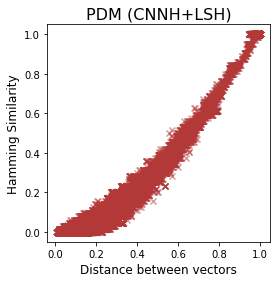

In [40]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Distance between vectors", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('PDM (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/PDM-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [23]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [18]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)

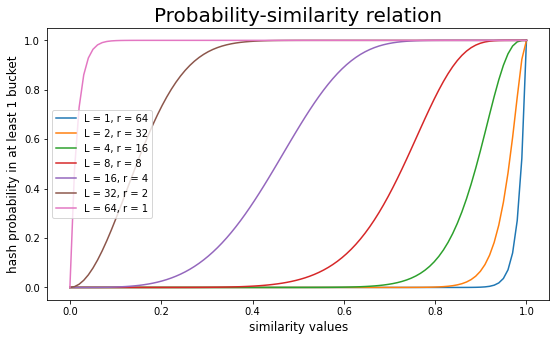

In [43]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 20)
plt.legend()

In [44]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'PDM', trace = False)

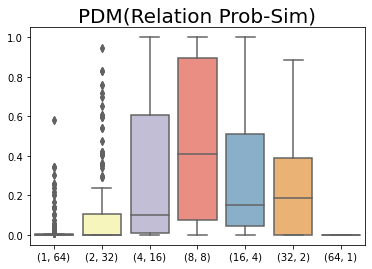

In [45]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.title('PDM(Relation Prob-Sim)', fontsize = 20)
plt.savefig('Results/Baseline/PDM-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [21]:
'L = K = 8'
L, K = params[3]
L, K

(8, 8)

### 4.1.1 Mean and Median probability for all stack traces for the best combination of $K$ and $L$

In [47]:
df_probLSH.mean()['(8, 8)']

0.4701355631766775

In [48]:
df_probLSH.median()['(8, 8)']

0.41146314833739817

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [24]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [50]:
with open('Hash-Tables/hash_tables_baseline.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [51]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

139

In [52]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{89, 139, 172, 230, 468, 503}

In [53]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [54]:
near_duplicates_sim = df_measures['PDM'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

129633    0.927532
129598    0.885487
85044     0.885487
129360    0.527989
129302    0.432281
Name: PDM, dtype: float64

In [55]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'PDM', n_stacks, n_duplicate_pairs)
set_real_nns

{34, 89, 230, 468, 503}

In [56]:
real_nns_sim[:n_duplicate_pairs]

129633    0.927532
85044     0.885487
129598    0.885487
129360    0.527989
33509     0.500651
dtype: float64

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [57]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'PDM')

0.798

In [58]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'PDM')

0.8822222222222222

-----------------------------------------------------------------

In [59]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'PDM')

0.760666666666667

In [60]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'PDM')

0.8902494331065761

-----------------------------------------------------------------

In [61]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'PDM')

0.7574000000000011

In [62]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'PDM')

0.8835637480798774

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))} $

In [63]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

0.8571428571428571

In [25]:
df_knns = mean_generalized_mrr(n_stacks, params, hash_vectors_hamming, b, df_measures ,'PDM', trace = False)
df_knns.mean(skipna = True, axis = 0)

(1, 64)    0.890020
(2, 32)    0.884849
(4, 16)    0.874536
(8, 8)     0.823674
(16, 4)    0.764429
(32, 2)    0.764510
(64, 1)    0.923894
dtype: float64

In [ ]:
df_knns.mean()['(8, 8)']

### 4.4.3. Recall w.r.t. LSH

In [26]:
df_recall = recall_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'PDM', trace = False)
df_recall.mean(skipna = True)

(1, 64)    1.000000
(2, 32)    0.953271
(4, 16)    0.928201
(8, 8)     0.764045
(16, 4)    0.684315
(32, 2)    0.497800
(64, 1)    0.728615
dtype: float64

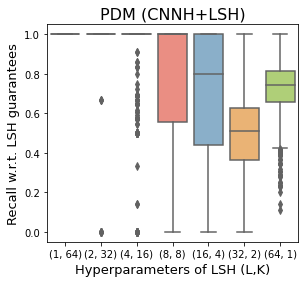

In [27]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Recall w.r.t. LSH guarantees", fontsize = 13)
plt.title('PDM (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/Recall-LSH', bbox_inches='tight')
plt.show()

### 4.4.4. Precison w.r.t. LSH

In [28]:
df_precision = precision_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'PDM', trace = False)
df_precision.mean(skipna = True, axis = 0)

(1, 64)    0.010046
(2, 32)    0.083494
(4, 16)    0.464077
(8, 8)     0.682222
(16, 4)    0.697508
(32, 2)    0.787190
(64, 1)    0.747322
dtype: float64

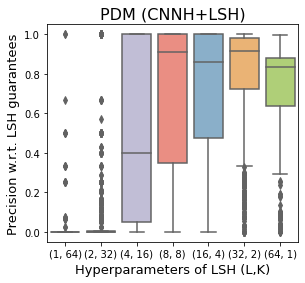

In [29]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Precision w.r.t. LSH guarantees", fontsize = 13)
plt.title('PDM (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/precision-LSH', bbox_inches='tight')
plt.show()

### 4.4.5. Fscore w.r.t. LSH

In [30]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

(1, 64)    0.013644
(2, 32)    0.106119
(4, 16)    0.505738
(8, 8)     0.630348
(16, 4)    0.621996
(32, 2)    0.559385
(64, 1)    0.707017
dtype: float64

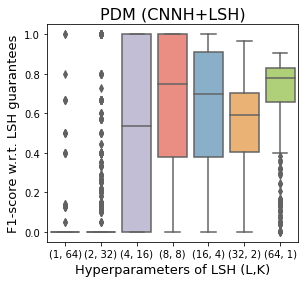

In [31]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 13)
plt.title('PDM (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/fscore-LSH', bbox_inches='tight')
plt.show()